In [1]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Two Gaussians

Visualize generated distribution, intended to look like graph on [page 3](https://arxiv.org/pdf/1806.08010.pdf)

init:
State(expected_populations=array([1000, 1000]), populations=array([1000, 1000]), features=array([[-1.13816802, -0.16071357],
       [-1.43872886, -0.01037741],
       [-0.66165873,  0.64558574],
       ...,
       [ 1.12437081, -0.08508197],
       [ 1.23598464, -0.15238307],
       [ 0.86702631,  0.38144057]]), labels=array([0, 1, 1, ..., 0, 1, 1]), classifier_params=array([-0.1570947 ,  6.74687162, -0.05352655]), risks=array([0.174, 0.204]))


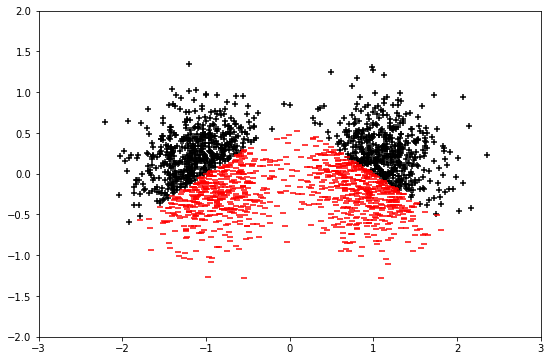

In [2]:
def graph_two_gaussians(features, labels, params=None):
    plt.figure(figsize=(9, 6))

    plt.scatter(*features[labels.astype(bool)].T, marker='+', color='k')
    plt.scatter(*features[(1 - labels).astype(bool)].T, marker='_', color='r')
    
    xlims = np.array([-3, 3])
    if params is not None:
        plt.plot(xlims, -params[0] / params[1] * xlims - params[2] / params[1], color='b')

    plt.xlim(xlims)
    plt.ylim((-2, 2))

    plt.show()


init = repeated_classification.experiments.sample_initial_states_gaussians(np.random.RandomState())
print('init:\n' + str(init))

graph_two_gaussians(init.features, init.labels)

Run to see progress at each step

In [3]:
import whynot as wn
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from whynot import repeated_classification
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

repeated_classification.TwoGaussiansExperiment.run(1)


0: expected pops [1825.3069 1815.4624], risks [0.177  0.1913], params [5.7007e-02 6.7584e+00 2.5124e-03]
20: expected pops [5728.356  5733.1003], risks [0.1919 0.1862], params [-0.0215  6.6776 -0.017 ]
40: expected pops [5841.8956 5791.9658], risks [0.1828 0.1891], params [-0.01    6.8085  0.0274]
60: expected pops [5908.157  5831.1771], risks [0.1848 0.1863], params [0.0156 6.8494 0.0224]
80: expected pops [5848.3992 5846.5205], risks [0.1811 0.1794], params [0.0494 6.8062 0.0337]
100: expected pops [5867.1214 5901.1554], risks [0.1902 0.1895], params [0.0759 6.715  0.0135]
120: expected pops [5890.9524 5878.4282], risks [0.1884 0.1854], params [ 0.      6.4692 -0.0161]
140: expected pops [5787.7383 5828.0844], risks [0.1859 0.1888], params [-0.0184  6.8583 -0.0143]
160: expected pops [5974.4215 5922.9909], risks [0.1853 0.1875], params [-0.009   6.7794  0.0217]
180: expected pops [5788.3077 5806.1655], risks [0.184  0.1941], params [0.0074 6.6993 0.0244]
200: expected pops [5875.023

Dataset(covariates=array([[0]]), treatments=array([0]), outcomes=array([0.18775438]), true_effects=array([0.00410403]), causal_graph=None)

Using `scipy.optimize.minimize` generally fits slightly better than using linear SVM

In [4]:
config = repeated_classification.experiments.construct_config_gaussians()
rng = np.random.RandomState()

POPULATIONS = [2000, 500]  # modify

features, labels = [], []
for pop, dist in list(zip(POPULATIONS, config.group_distributions)):
    features_k, labels_k = dist(pop, rng)
    features.append(features_k)
    labels.append(labels_k)
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# SVM
c_values = [0.01, 0.1, 1, 10]
models = [SVC(C=c, kernel='linear').fit(features, labels) for c in c_values]
params = [np.concatenate([m.coef_.flatten(), m.intercept_.flatten()]) for m in models]
accuracies = [
    np.count_nonzero(labels == repeated_classification.experiments.linear_classifier_2d(features, p, None))
    for p in params
]
for (c, acc) in zip(c_values, accuracies):
    print('linear SVM with C = {: >6.2f} :  {:>6d} / {} correct'.format(c, acc, len(labels)))

# Logistic regression
penalties = ['l1', 'l2']
models = [LogisticRegression(penalty=p).fit(features, labels) for p in penalties]
params = [np.concatenate([m.coef_.flatten(), m.intercept_.flatten()]) for m in models]
accuracies = [
    np.count_nonzero(labels == repeated_classification.experiments.linear_classifier_2d(features, p, None))
    for p in params
]
for (p, acc) in zip(penalties, accuracies):
    print('Logistic regression with {} :  {:>6d} / {} correct'.format(p, acc, len(labels)))

# ERM with scipy.optimize.minimize
erm_params = repeated_classification.experiments.erm(
    config,
    features,
    labels,
    [0, 1, 0],
    rng,
    method='Powell'
)
erm_acc = np.count_nonzero(
    labels == repeated_classification.experiments.linear_classifier_2d(features, erm_params, None)
)
print('scipy.optimize.minimize    :  {: >6d} / {} correct'.format(erm_acc, len(labels)))

linear SVM with C =   0.01 :    2034 / 2500 correct
linear SVM with C =   0.10 :    2032 / 2500 correct
linear SVM with C =   1.00 :    2032 / 2500 correct
linear SVM with C =  10.00 :    2028 / 2500 correct
Logistic regression with l1 :    2030 / 2500 correct
Logistic regression with l2 :    2031 / 2500 correct
scipy.optimize.minimize    :    2041 / 2500 correct


# Median Estimation

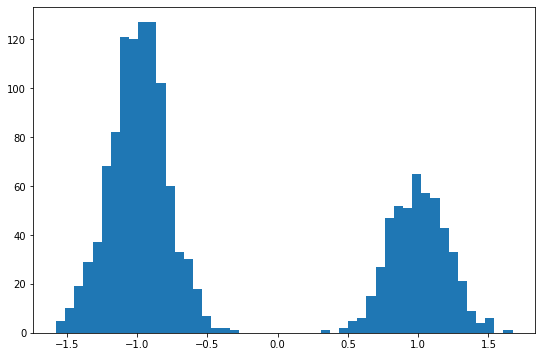

In [5]:
def graph_median_setup(pop1, pop2):
    data = np.concatenate([np.random.normal(-1, 0.2, pop1), np.random.normal(1, 0.2, pop2)], axis=0)
    plt.figure(figsize=(9, 6))
    plt.hist(data, bins=50)
    plt.show()


graph_median_setup(1000, 500)

In [1]:
import whynot as wn
import numpy as np
from whynot import repeated_classification

repeated_classification.MedianEstimationExperiment.run(1)


0: expected pops [1763.0291  473.6134  470.3503], risks [0.2629 0.5738 0.5506], params [0.6538 0.1713 0.1695]
20: expected pops [5011.3615  601.2402  607.2913], risks [0.2216 0.6949 0.7065], params [0.8089 0.0899 0.106 ]
40: expected pops [5078.013   599.2435  603.2358], risks [0.216  0.6792 0.6814], params [0.8096 0.0934 0.0891]
60: expected pops [5075.9921  598.3903  605.8382], risks [0.2134 0.6926 0.6756], params [0.8033 0.1009 0.0873]
80: expected pops [5092.1612  595.6738  593.5897], risks [0.2163 0.6958 0.6823], params [0.8054 0.0929 0.094 ]
100: expected pops [5118.597   611.5346  593.9166], risks [0.2174 0.6708 0.7097], params [0.8056 0.0913 0.0919]
120: expected pops [5126.7475  591.2798  597.7295], risks [0.2136 0.7167 0.6919], params [0.8124 0.1087 0.0881]
140: expected pops [5111.5864  595.4863  600.8806], risks [0.2149 0.7024 0.7156], params [0.8134 0.0889 0.0831]
160: expected pops [5099.3511  595.6381  605.9089], risks [0.2189 0.6888 0.669 ], params [0.8101 0.0878 0.085

Dataset(covariates=array([[0.60170019, 0.21340439, 0.20397633]]), treatments=array([0]), outcomes=array([0.72056836]), true_effects=array([-0.21986478]), causal_graph=None)

two gaussians:
logistic regression with not 0-1 loss
different retention




Walk through how to run this experiment

Intervention on retention dynamics

some kind of dynamic intervention to showcase more of whynot

performative prediction

In [8]:
MedianEstimationExperiment = DynamicsExperiment(
    name="MedianEstimationExperiment",
    description="",  # TODO: description
    simulator=repeated_classification,
    simulator_config=construct_config_median,
    intervention=repeated_classification.Intervention(time=0, train_classifier=dro),
    state_sampler=sample_initial_states_median,
    propensity_scorer=0.5,
    outcome_extractor=extract_outcomes,
    covariate_builder=lambda run: 0,  # TODO: change
)

NameError: name 'DynamicsExperiment' is not defined